# Một số thủ thuật pandas dùng cho panel data

### BS. Lê Ngọc Khả Nhi

# Nhập đề

Panel data, tạm dịch: dữ liệu hỗn hợp là một cấu trúc bảng dọc (long format) ghi thông tin trong nghiên cứu longitudinal. Panel data có hệ thống chỉ mục đa chiều là kết quả tổ hợp giữa cá thể (bệnh nhân), thời điểm khảo sát (mỗi bệnh nhân được khảo sát nhiều lần tại nhiều thời điểm khác nhau) và phân nhóm điều trị, kết cục lâm sàng hay những yếu tố phân nhóm khác. Panel data chứa đồng thời dữ liệu chuỗi (theo trình tự thời gian, có chu kì hoặc không) và dữ liệu cắt ngang (duy nhất 1 giá trị đại diện cho mỗi bệnh nhân). 

Dạng dữ liệu hỗn hợp này rất thường gặp trong một số chuyên khoa và vấn đề bệnh lý, thí dụ: Sản khoa (dữ liệu theo dõi kéo dài cho mỗi sản phụ trong thai kì), Nhi khoa (theo dõi tăng trưởng ở nhỏ), bệnh lý tự miễn (bệnh nhân được tái khám theo định kì, kéo dài suốt đời, hồi sức cấp cứu/chăm sóc tích cực (diễn tiến lâm sàng trong thời gian điều trị), các bệnh lý mạn tính (nhật ký lưu lượng đỉnh trong bệnh hen phế quản), nội tiết (theo dõi đường huyết kéo dài), hóa trị liệu ung thư. Đặc biệt, với công nghệ hiện đại, xuất hiện ngày càng nhiều hình thức xét nghiệm tại nhà và theo dõi bệnh lý kéo dài, sinh ra dữ liệu chuỗi và tích hợp chúng vào nghiên cứu lâm sàng.

Do có cấu trúc chỉ mục và thông tin đa chiều, panel data đặt ra những tình huống khó khăn cho chuyên viên thống kê khi viết code lập trình. Trong bài thực hành này, Nhi sẽ chia sẻ một số code snipet sử dụng thư viện pandas trong ngôn ngữ Python để thực hiện một số quy trình trên panel data nghiên cứu y học. 

Thí dụ minh họa trong bài là bộ dữ liệu Mayo Clinic Primary Biliary Cirrhosis (PBC), đây là một bộ dữ liệu kinh điển cho bài toán Survival analysis, longitudinal data và mô hình hồi quy hỗn hợp. Nhi sẽ lần lượt đặt ra những câu hỏi mà nghiên cứu sinh có thể gặp, và cách giải quyết chúng bằng pandas. 

# Khởi hành

Trước hết, mời các bạn tải dữ liệu này về từ github của Nhi, và import pandas

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Tải file PBC2.csv vào dataframe df như sau:

In [2]:
df = pd.read_csv('PBC2.csv', sep = ';')

df.head(6)

,id,years,status,drug,age,sex,year,ascites,hepatomegaly,spiders,edema,serBilir,serChol,albumin,alkaline,SGOT,platelets,prothrombin,histologic,status2
0,1,1.095170,dead,D-penicil,58.766838,female,0.000000,Yes,Yes,Yes,edema despite diuretics,14.5,261.0,2.60,1718.0,138.0,190.0,12.2,4,1
1,1,1.095170,dead,D-penicil,58.766838,female,0.525682,Yes,Yes,Yes,edema despite diuretics,21.3,NaN,2.94,1612.0,6.2,183.0,11.2,4,1
2,2,14.152338,alive,D-penicil,56.447815,female,0.000000,No,Yes,Yes,No edema,1.1,302.0,4.14,7395.0,113.5,221.0,10.6,3,0
3,2,14.152338,alive,D-penicil,56.447815,female,0.498302,No,Yes,Yes,No edema,0.8,NaN,3.60,2107.0,139.5,188.0,11.0,3,0
4,2,14.152338,alive,D-penicil,56.447815,female,0.999343,No,Yes,Yes,No edema,1.0,NaN,3.55,1711.0,144.2,161.0,11.6,3,0
5,2,14.152338,alive,D-penicil,56.447815,female,2.102727,No,Yes,Yes,No edema,1.9,NaN,3.92,1365.0,144.2,122.0,10.6,3,0


# Câu hỏi 1: Có bao nhiêu bệnh nhân trong nghiên cứu ?

Khác với những dữ liệu thông thường, mỗi hàng trong panel data không tương ứng với 1 cá thể bệnh nhân, do đó ta không thể đếm số hàng để biết có bao nhiêu bệnh nhân: df này có 1945 hàng

In [3]:
df.shape[0]

1945

Nhưng phải dựa vào cột id, mã số bệnh nhân. Cách làm là kết hợp method unique() và len, ta sẽ có số bệnh nhân là 312

In [4]:
len(df['id'].unique())

312

# Câu hỏi 2: Tỉ lệ của mỗi phân nhóm can thiệp như thế nào ?

Với câu hỏi này, thông thường ta sẽ dùng công cụ bảng chéo hoặc kết hợp method groupby và phép đếm, tuy nhiên sau câu 1, ta đã rút ra một kinh nghiệm đó là bất cứ một phép đếm tần suất nào có đơn vị là bệnh nhân, đều phải dựa vào cột id và rút gọn nó để chỉ giữ lại 1 giá trị id duy nhất.

Sau đây là 3 giải pháp cho câu hỏi này, 2 cách đầu tiên áp dụng groupby cho phân nhóm điều trị 'drug', sau đó dùng method unique cho cột 'id', kết quả sẽ là 1 arrays cho mỗi phân nhóm, dùng hàm len() trên array này sẽ cho ra tần suất.

Cách thứ 3 tiếp cận bằng cột id, sau đó ta chọn biến drug, sẽ tạo ra series, áp dụng hàm lambda cho series x này để lấy giá trị đầu tiên cho mỗi phân cụm id, rồi gom lại, ta sẽ có 1 series mới chỉ còn 312 giá trị drugs, lúc này ta có thể dùng value_counts để đếm tần suất của mỗi phân nhóm drug

In [14]:
df.groupby(['drug'])['id'].unique().apply(len)

drug
D-penicil    158
placebo      154
Name: id, dtype: int64

In [12]:
df.groupby(['drug'])['id'].agg(lambda x: len(x.unique()))

drug
D-penicil    158
placebo      154
Name: id, dtype: int64

In [33]:
df.groupby(['id'])['drug'].agg(lambda x: x.iloc[0]).value_counts()

D-penicil    158
placebo      154
Name: drug, dtype: int64

# Câu hỏi 3: Phân bố kết cục lâm sàng ở mỗi phân nhóm can thiệp ?

Sau khi giải quyết xong câu 2, ta đã nắm được quy tắc để đếm tần suất của bất cứ tổ hợp nào giữa 2 biến định tính, chìa khóa là phải rút gọn id về 1 giá trị id duy nhất cho mỗi bệnh nhân.

Câu 3 giải quyết giống y như câu 2, với 2 cách:

In [42]:
df.groupby(['id'])[['drug','status']].agg(lambda x: x.iloc[0]).value_counts()

drug       status      
D-penicil  alive           75
           dead            71
placebo    dead            69
           alive           68
           transplanted    17
D-penicil  transplanted    12
dtype: int64

In [43]:
df.groupby(['drug','status'])['id'].unique().apply(len)

drug       status      
D-penicil  alive           75
           dead            71
           transplanted    12
placebo    alive           68
           dead            69
           transplanted    17
Name: id, dtype: int64

# Câu hỏi 4: So sánh thời gian sống trung bình giữa 2 phân nhóm can thiệp x 3 kết cục khác nhau:

Đây là một nghiên cứu longitudinal đồng thời cũng là 1 bài toán Survival analysis, biến years trong df chỉ thời gian sống (nếu bệnh nhân tử vong), thời gian đến lúc ghép gan (nếu bệnh nhân được ghép gan, và thời gian sống sót cho đến kết thúc nghiên cứu. Biến status là kết cục lâm sàng.

Như đã giải thích, có 2 loại thông tin định lượng trong panel data, loại thứ nhất có ý nghĩa đại diện, hoặc cắt ngang, nó chỉ có 1 giá trị duy nhất không đổi cho toàn bộ các hàng cho mỗi bệnh nhân. Thời gian sống (years) thuộc loại này.

Do biến years này có giá trị như nhau ở toàn bộ các hàng cho mỗi bệnh nhân, nhiều bạn sẽ nghĩ ra cách làm "ngây thơ" là áp dụng group_by cho tổ hợp drug và status, sau đó áp dụng hàm mean cho years, khi đó ta sẽ thu được kết quả như sau:

In [106]:
df.groupby(['drug','status'])['years'].agg('mean')

drug       status      
D-penicil  alive           9.829064
           dead            5.955559
           transplanted    4.532427
placebo    alive           9.697063
           dead            6.203813
           transplanted    5.768685
Name: years, dtype: float64

Một số bạn khác, cẩn thận hơn, sẽ áp dụng 2 lần groupby+mean, lần thứ nhất cho tổ hợp id/drug/status, sẽ tạo ra cho mỗi bệnh nhân 1 giá trị years đại diện, lần thứ 2 ta áp dụng groupby cho drug và status, rồi tính trung bình của tất cả giá trị years đại diện này, kết quả ra như sau:

In [91]:
df.groupby(['id','drug','status'])['years'].agg(lambda x: x.mean()).groupby(['drug','status']).agg('mean')

drug       status      
D-penicil  alive           8.614281
           dead            4.517925
           transplanted    4.034562
placebo    alive           8.780004
           dead            4.344612
           transplanted    5.189980
Name: years, dtype: float64

Như các bạn thấy, 2 cách làm này cho ra 2 kết quả khác nhau, cách nào là đúng ?

Câu trả lời, đó là cách làm đầu tiên không chính xác, cách thứ 2 mới là chính xác. Bởi vì tuy mỗi bệnh nhân có cùng giá trị years cho tất cả thời điểm, nhưng số lần khám bệnh lại khác nhau, có người khám 10 lượt, có người chỉ có 2 (nhất là bệnh nhân tử vong sớm).

Khi độ dài chuỗi không đồng đều, cách thứ 1 trở nên không chính xác, ta có thể thử qua 4 thí dụ sau đây:

array 1: mỗi giá trị lặp lại 2 lần như nhau, trung bình = 3.5

array 2: các chuỗi giá trị có độ dài khác nhau, trung bình khác với 3.5

array 3: áp dụng hàm mean cho mỗi cụm giá trị trong array 2, ta có trung bình = 3.5

array 4: kết quả rút gọn của array 3, trung bình của nó cũng là 3.5

In [7]:
np.array([2,2,2,3,3,3,4,4,4,5,5,5,]).mean(), \
np.array([2,2,3,3,3,4,4,4,4,5,5,5,5,5,]).mean(), \
np.array([np.mean([2,2]),np.mean([3,3,3]),np.mean([4,4,4,4]),np.mean([5,5,5,5,5])]).mean(), \
np.array([2,3,4,5]).mean()

(3.5, 3.857142857142857, 3.5, 3.5)

# Câu hỏi 5: So sánh giá trị trung bình SGOT giữa 2 phân nhóm can thiệp x 3 kết cục khác nhau:

Khác với years, SGOT là một dữ liệu chuỗi, mỗi lần khám sẽ cho ra một giá trị SGOT khác nhau trong thời gian theo dõi của bệnh nhân, do đó, ta có thể dùng cách thứ 1: 

In [8]:
df.groupby(['drug','status'])['SGOT'].agg('mean')

drug       status      
D-penicil  alive            93.951083
           dead            142.794247
           transplanted    151.506780
placebo    alive           109.761272
           dead            152.211944
           transplanted    155.952273
Name: SGOT, dtype: float64

# Câu hỏi 6: So sánh trung vị SGOT đầu tiên giữa 2 phân nhóm can thiệp x 3 kết cục khác nhau

Câu 5 được giải quyết dễ dàng, nhưng không phải là câu hỏi hay. Để việc so sánh có ý nghĩa hơn, ta không nên lấy trung bình của tất cả các lần khám, mà nên xét cho 1 thời điểm nhất định và đồng nhất ở mỗi bệnh nhân, thí dụ lần khám đầu tiên trước khi bệnh nhân được chia nhóm điều trị (baseline value).

Tất cả những phép thống kê trên dữ liệu 1 thời điểm xác định trong chuỗi dữ liệu cá thể đểu phải đi qua groupby(id) (vì cho cá thể), sau đó ta dùng apply và 1 hàm lambda để trích xuất giá trị đầu tiên x.iloc[0], kết quả tạo ra 1 df rút gọn, ta lại áp dụng groupby lần nữa cho drug và status để tính trung vị của SGOT bằng aggregate:

In [52]:
df.groupby(['id'])[['drug','status','SGOT']].apply(lambda x: x.iloc[0])

,drug,status,SGOT
id,,,
1,D-penicil,dead,138.0
2,D-penicil,alive,113.5
3,D-penicil,dead,96.1
4,D-penicil,dead,60.6
5,placebo,transplanted,113.2
...,...,...,...
308,D-penicil,alive,91.0
309,placebo,alive,70.0
310,D-penicil,alive,171.0


In [51]:
df.groupby(['id'])[['drug','status','SGOT']].apply(lambda x: x.iloc[0]).groupby(['drug','status']).agg('median')

SGOT
drug      status              
D-penicil alive          93.00
          dead          128.70
          transplanted  127.50
placebo   alive          97.35
          dead          135.00
          transplanted  117.00

# Câu hỏi 7: Tính trung bình của giá trị SGOT cao nhất của mỗi bệnh nhân và so sánh giữa 3 kết cục lâm sàng

Với câu hỏi này, yêu cầu đặt ra là đầu tiên xác định giá trị cao nhất trong chuỗi SGOT của mỗi bệnh nhân, sau đó tính trung bình cho 3 phân nhóm kết cục lâm sàng.

Nếu đã làm được câu 6, ta sẽ nhận ra hàm lambda x: cho phép thao tác trên x là chuỗi dữ liệu SGOT, do đó ta chỉ cần thay x.iloc[0] bằng x.max(), phần còn lại tương tự:

In [58]:
df.groupby(['id'])[['status','SGOT']].apply(lambda x: x.max()).groupby(['status']).agg('mean')

,SGOT
status,
alive,150.437762
dead,196.900714
transplanted,189.686207


# Câu hỏi 8: Hãy hoán chuyển dữ liệu SGOT thành mức thay đổi của SGOT so với thời điểm ban đầu

Đây là 1 câu hỏi thú vị, yêu cầu đặt ra là cho mỗi bệnh nhân, ta phải lấy mỗi giá trị SGOT trừ cho giá trị SGOT ở baseline của chính bệnh nhân đó. Mức độ thay đổi tại mỗi thời điểm so với giá trị baseline có nhiều ứng dụng trên lâm sàng, thí dụ đánh giá đáp ứng điều trị của một loại hormone (điều trị nội khoa thai ngoài tử cung), hay biomarker (ung thư tiền liệt tuyến), khảo sát liều/đáp ứng trong xét nghiệm phản ứng tính phế quản, ...

Ta có thể giải quyết bằng 1 hàm rời để tính thay đổi so với baseline, rồi dùng method transform để áp dụng hàm này:

Lưu ý; phải groupby(id) trước

In [68]:
def change_from_baseline(x):
    return x.apply(lambda v: v-x.values[0])

df.groupby('id')['SGOT'].transform(change_from_baseline)

0         0.0
1      -131.8
2         0.0
3        26.0
4        30.7
        ...  
1940      0.0
1941    -12.0
1942     30.0
1943     37.0
1944     64.0
Name: SGOT, Length: 1945, dtype: float64

# Câu hỏi 9: Hãy hoán chuyển dữ liệu SGOT thành mức thay đổi của SGOT so với thời điểm ngay trước nó

Yêu cầu lần này là ta muốn đổi giá trị là tại mỗi thời điểm trên chuỗi dữ liệu của mỗi bệnh nhân thành khác biệt so với giá trị ngay trước nó. pandas đã có sẵn hàm diff() cho phép làm việc này. Lưu ý: method diff sẽ xuất kết quả NA cho giá trị đầu tiên, do đó ta phải dùng thêm fillna(0) để lấp đầy những giá trị NA này.

In [71]:
df.groupby('id')['SGOT'].apply(lambda x: x.diff()).fillna(0)

0         0.0
1      -131.8
2         0.0
3        26.0
4         4.7
        ...  
1940      0.0
1941    -12.0
1942     42.0
1943      7.0
1944     27.0
Name: SGOT, Length: 1945, dtype: float64

# Câu hỏi 10: Thống kê số bệnh nhân có SGOT tăng cao hơn 50% so với baseline trong mỗi phân nhóm điều trị/kết cục ?

Đây là một câu hỏi khá phức tạp, và có ứng dụng thực tế trên lâm sàng cho nhiều chuyên khoa, thí dụ trong phác đồ điều trị nội khoa thai ngoài tử cung, đáp ứng giảm beta-HCG hơn 50% so với baseline có ý nghĩa tích cực, tương tự, biến cố FEV1 giảm hơn 20% so với giá trị baseline trong test phản ứng tính phế quản cho ra kết quả test dương tính.

Ta giải quyết theo từng bước:

Đầu tiên, cần tạo ra 1 biến mới tên là Rise, chứa giá trị thay đổi SGOT theo tỉ lệ so với baseline, ta làm tương tự câu 8 với 1 hàm rời.

Sau đó, ta tiến hành 2 lần groupby, lần thứ nhất cho id, drug, status, ta kiểm tra mỗi bệnh nhân có bất kì (any) giá trị Rise nào > 0.5, kết quả sẽ là 1 dataframe, ta groupby lần nữa trên dataframe này, dùng agg với hàm sum để tính tổng giá trị boolean (True = 1) thì sẽ ra kết quả cần tìm.

In [113]:
def pct_change_from_baseline(x):
    return x.apply(lambda v: (v-x.values[0])/x.values[0])

df['Rise'] = df.groupby('id')['SGOT'].transform(pct_change_from_baseline)

df['Rise']

0       0.000000
1      -0.955072
2       0.000000
3       0.229075
4       0.270485
          ...   
1940    0.000000
1941   -0.088235
1942    0.220588
1943    0.272059
1944    0.470588
Name: Rise, Length: 1945, dtype: float64

In [115]:
df.groupby(['id','drug','status'])[['Rise']].agg(lambda x: any(x > 0.5)).groupby(['drug','status']).agg('sum')

Rise
drug      status            
D-penicil alive           22
          dead            19
          transplanted     3
placebo   alive           20
          dead            27
          transplanted     8

# Câu hỏi 11: Thống kê số bệnh nhân có SGOT tăng và Albumin giảm ở cuối nghiên cứu so với baseline 

Câu hỏi này có cùng một hướng giải quyết như câu 10, nhưng phức tạp hơn một chút, vì ta phải kiểm tra đồng thời 2 điều kiện: SGOT ở vị trí cuối (-1) có cao hơn SGOT ban đầu (0) hay không, và ngược lại cho albumin, ta có thể dùng 1 hàm rời và tạo 1 biến trung gian như trên, hoặc có thể làm trực tiếp trong 1 dòng code duy nhất như sau:

In [110]:
df.groupby(['id','drug','status'])[['SGOT','albumin']].apply(lambda g: (g.albumin.values[-1] < g.albumin.values[0]) & (g.SGOT.values[-1] > g.SGOT.values[0])).groupby(['drug','status']).agg('sum')

drug       status      
D-penicil  alive           18
           dead            34
           transplanted     5
placebo    alive           20
           dead            34
           transplanted    13
dtype: int64

# Câu hỏi 12: Vẽ biểu đồ tuyến kí mô tả diễn tiến SGOT cho tất cả bệnh nhân có từ 10 lần khám trở lên và có SGOT tăng cao hơn 50%

method groupby trong pandas không chỉ dùng để làm thống kê hay hoán chuyển dữ liệu, nó còn có thể dùng để vẽ biểu đồ.

Trong thí dụ này, Nhi viết 1 hàm rời draw_line, nó sẽ kiểm tra dataframe đầu vào : có độ dài lớn hơn hay bằng 10, SGOT không chứa NA, và có bất cứ giá trị biến Rise nào cao hơn 50%, nếu thỏa cả 3 điều kiện, sẽ vẽ 1 lineplot với trục hoành là year (thời gian chính xác giữa 2 lần khám, và trục tung là SGOT

In [208]:
import seaborn as sns
sns.set_palette('viridis')

def draw_line(x):
    if (len(x) >= 10) & (x['Rise'].isna().sum()==0) & (any(x['Rise']) > 0.5):
        plt.plot(x['year'].values, x['SGOT'].values,'-', alpha = 0.3)

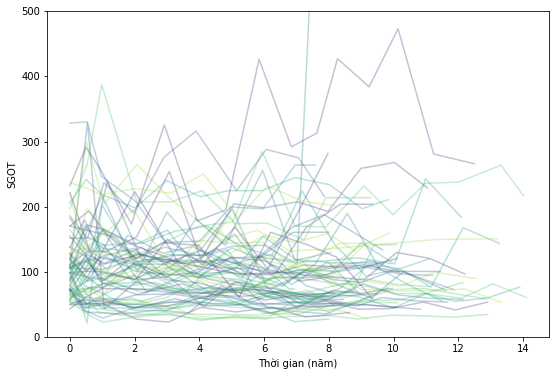

In [209]:
plt.rcParams["figure.figsize"] = (9,6)
plt.ylim(0,500)
df.groupby('id').apply(draw_line)
plt.xlabel('Thời gian (năm)')
plt.ylabel('SGOT')
plt.show()

# Tổng kết

Qua bài thực hành này, ta đã rút ra một số kinh nghiệm về công dụng của những method groupby, aggregate, apply, transform mà thư viện pandas cung cấp, cho phép giải quyết nhiều vấn đề trên dữ liệu hỗn hợp (panel data). Chúc các bạn thực hành vui.